In [3]:
import numpy as np
import matplotlib.pyplot as plt

#### Declare Variables 

In [4]:
n_states = 20 #number of states in the GMM
poly_deg = 2 #Degree of the polynomial
n_out = 2 #number of motion variables
n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations
t_in = np.linspace(0,1,n_data) #input data for LWR

#### Load Data 

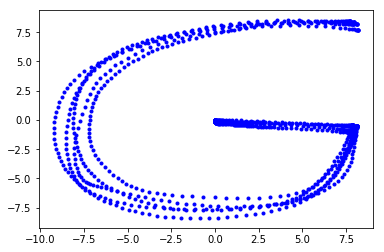

In [5]:
ROOT = 'python_data/2Dletters/'
data = np.load(ROOT + 'G.npy')[1:n_samples+1]

#construct the output Y by concatenating all demonstrations
data = data.transpose([0,2,1])
Y = np.concatenate(data,axis=0)

plt.plot(Y[:,0], Y[:,1],'.b')

#### Set the basis functions 

In [6]:
t_sep = np.linspace(-0.3,1.3,n_states+1)
mus = np.zeros(n_states)
for i in range(n_states):
    mus[i] = 0.5*(t_sep[i]+t_sep[i+1])

sigmas = np.array([2e-3]*n_states)

In [7]:
from scipy.stats import norm as normal_dist

#### Compute the activation weigths

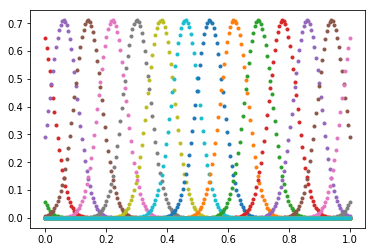

In [8]:
H = np.zeros((n_states, n_data))
for i in range(n_states):
    H[i] = normal_dist(loc = mus[i], scale = np.sqrt(sigmas[i])).pdf(t_in)
H /= np.sum(H,axis=0) #normalizing the weights

for i in range(n_states):
    plt.plot(t_in, H[i],'.')

Hn = np.tile(H,(1,n_samples)) #repeat Hn for n samples

#### Compute LWR 

In [9]:
#construct the polynomial input of degree=poly_deg

In [10]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=poly_deg)
Xr = poly.fit_transform(t_in[:,None])
X = np.tile(Xr,(n_samples,1))

/home/teguh/.local/lib/python2.7/site-packages/sklearn/utils/__init__.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/home/teguh/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/home/teguh/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sparsefuncs_fast import csr_row_norms


In [11]:
from numpy import dot
from numpy.linalg import inv

In [12]:
As = []
for i in range(n_states):
    W = np.diag(Hn[i])
    A = dot(inv(dot(X.T,dot(W,X))+np.eye(poly_deg+1)*1e-5),dot(X.T, dot(W,Y)))
    As.append(A)

In [13]:
%matplotlib inline

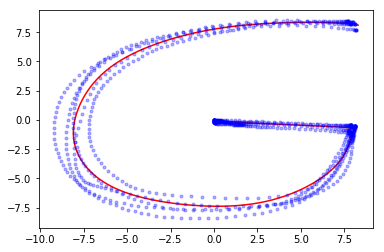

In [14]:
Y_preds = []
for i in range(n_states):
    Y_pred = np.multiply(H[i][:,None], dot(Xr,As[i]))
    Y_preds.append(Y_pred)
    
Y_preds = np.array(Y_preds)
Y_preds = np.sum(Y_preds, axis=0)

plt.plot(Y_preds[:,0], Y_preds[:,1],'-r', alpha=1)
plt.plot(Y[:,0], Y[:,1],'.b', alpha=0.3)

In [15]:
%matplotlib inline

/home/teguh/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


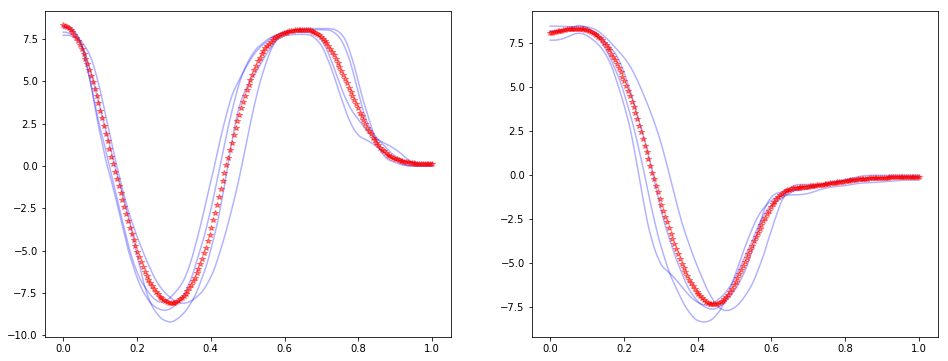

In [16]:
plt.figure(figsize=(16, 6))
for i in range(1,n_samples):
    plt.subplot(1,2,1)
    plt.plot(t_in, Y[i*n_data:(i+1)*n_data,0],'-b', alpha=0.3)
    plt.subplot(1,2,2)
    plt.plot(t_in, Y[i*n_data:(i+1)*n_data,1],'-b',alpha=0.3)

plt.subplot(1,2,1)    
plt.plot(t_in, Y_preds[:,0], '*r', alpha=0.5)
plt.subplot(1,2,2)
plt.plot(t_in, Y_preds[:,1], '*r', alpha=0.5)


## Gaussian Mixture Regression (GMR)

#### Declare parameters


In [131]:
n_states = 6

#### Concatenate time to the data 

In [132]:
data_time = np.zeros((data.shape[0], data.shape[1], data.shape[2]+1))
for i in range(n_samples):
    data_time[i] = np.hstack([t_in[:,None], data[i]])
    
#concatenate the whole samples
data_time = np.concatenate(data_time,axis=0)

#### Estimate GMM using the data 

(-10.180600969272122,
 10.176265192667167,
 -9.358332173409938,
 9.433837476940791)

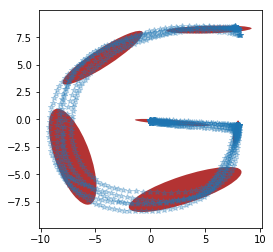

In [155]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = n_states,n_init = 4)
gmm.fit(data_time)

#plot only the spatial components
fig, ax = plt.subplots(figsize = (4,4))
plot_GMM(gmm.means_[:,1:], gmm.covariances_[:,1:,1:],ax)
plt.axis([-13,10,-20,20])
plt.plot(data_time[:,1],data_time[:,2], '*' ,alpha=0.3)
plt.axis('equal')

#### GMR based on the GMM 

In [141]:
gmr = GMR(gmm,n_in = 1, n_out = 2)

#### Predict the data based on the time input

In [156]:
y_preds = []
covs = []
for t in t_in:
    y,cov = gmr.predict(t)
    y_preds.append(y)
    covs.append(cov)
    
y_preds = np.array(y_preds)
covs = np.array(covs)
print ys.shape, covs.shape

(200, 2) (200, 2, 2)


#### Plot data 

(-10.14921159032198, 10.2951851424694, -9.22349093629936, 9.367081367719946)

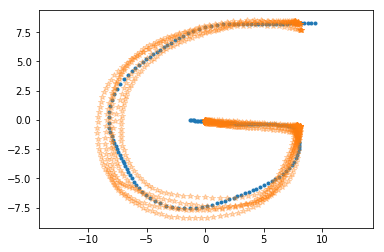

In [158]:
plt.plot(ys[:,0], ys[:,1], '.')
plt.axis([-13,10,-20,20])
plt.plot(data_time[:,1],data_time[:,2], '*' ,alpha=0.3)
plt.axis('equal')

In [182]:
y_covs = covs[:,0,0]
print y_covs.shape, ys[:,0].shape

(200,) (200,)


In [183]:
from matplotlib.patches import Polygon

In [210]:
def plot_with_covs_1D(x, y, cov, ax):
    y_low = y - 2*np.sqrt(cov)
    y_up = y + 2*np.sqrt(cov)
    y_up = y_up[::-1]
    
    x_1 = np.concatenate([x, x[::-1]])
    y_1 = np.concatenate([y_low, y_up])
    xy = np.vstack([x_1,y_1]).T
    poly = Polygon(xy,alpha=0.4)
    ax.add_patch(poly)
    
    plt.plot(x,y,'-r')

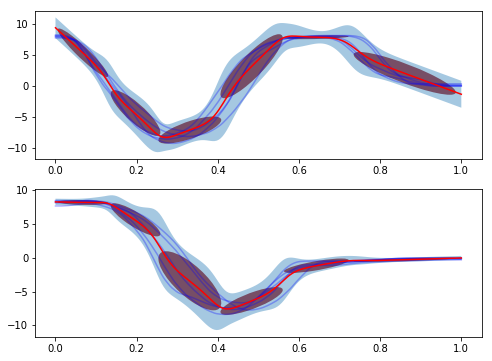

In [217]:
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(2,1,1)
plot_GMM(gmm.means_[:,0:2], gmm.covariances_[:,:2,:2], ax)
for i in range(n_samples):
    plt.plot(t_in, data[i,:,0], '-b',alpha = 0.3)

#plot covariances
y_covs1 = covs[:,0,0]
plot_with_covs_1D(t_in, ys[:,0],y_covs1, ax)


ax = plt.subplot(2,1,2)
plot_GMM(gmm.means_[:,0::2], gmm.covariances_[:,::2,::2], ax)
for i in range(n_samples):
    plt.plot(t_in, data[i,:,1], '-b',alpha = 0.3)
#plot covariances
y_covs2 = covs[:,1,1]
plot_with_covs_1D(t_in, ys[:,1],y_covs2, ax)

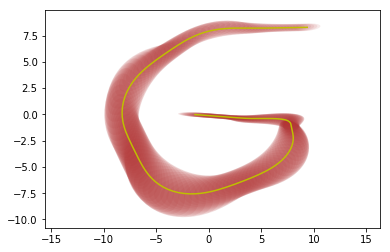

In [246]:
for i in range(n_data):
    mu = ys[i,:]
    sigma = covs[i]
    plot_gaussian_2D(mu,sigma,ax,alpha=0.1)
plt.axis([-13,10,-20,20])
plt.axis('equal')
plt.plot(ys[:,0], ys[:,1], 'y')

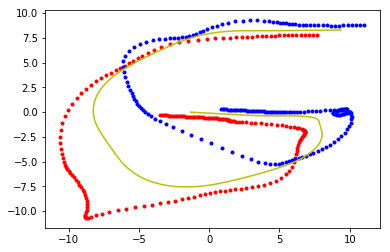

In [228]:
plt.plot(x_low, y_low,'.r')
plt.plot(x_up, y_up,'.b')
plt.plot(ys[:,0], ys[:,1], 'y')

(-11.70817531774468,
 12.118072450495974,
 -11.692036130291184,
 10.265864689806067)

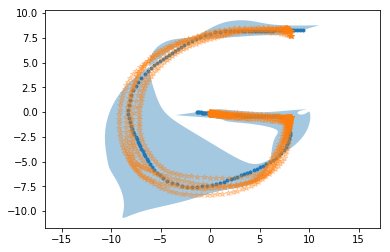

In [224]:
x_low = ys[:,0] - 2*np.sqrt(y_covs1)
x_up = ys[:,0] + 2*np.sqrt(y_covs1)

y_low = ys[:,1] - 2*np.sqrt(y_covs2)
y_up = ys[:,1] + 2*np.sqrt(y_covs2)

x_1 = np.concatenate([x_low, x_up[::-1]])
y_1 = np.concatenate([y_low, y_up[::-1]])
xy = np.vstack([x_1,y_1]).T
poly = Polygon(xy,alpha=0.4)
fig,ax = plt.subplots()
ax.add_patch(poly)
plt.axis([-13,10,-20,20])
#plt.plot(x,y,'-r')

plt.plot(ys[:,0], ys[:,1], '.')
plt.axis([-13,10,-20,20])
plt.plot(data_time[:,1],data_time[:,2], '*' ,alpha=0.3)
plt.axis('equal')

#### GMM codes 